In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic, dimensionless

In [2]:
perturbers = {
    'kepler': gp.KeplerPotential(m=1., units=dimensionless),
    'hernquist': gp.HernquistPotential(m=4., c=1., units=dimensionless),
    'plummer': gp.PlummerPotential(m=2*np.sqrt(2), b=1., units=dimensionless),
    'nfw': gp.NFWPotential(m=1/(np.log(2) - 0.5), r_s=1., units=dimensionless),
}

In [3]:
for k, p in perturbers.items():
    print(p.mass_enclosed([1., 0, 0]))

[1.00000001]
[1.]
[1.]
[1.]


## Perturb a test particle

All coordinates are at the time of impact

In [35]:
perturber_w0 = gd.PhaseSpacePosition([0,0,0], [0,0,10.])

In [55]:
par_pos = np.zeros((3, 128))
par_pos[0] = np.logspace(-2, 2, par_pos.shape[1])
par_vel = np.zeros_like(par_pos)
particle_w0 = gd.PhaseSpacePosition(par_pos, par_vel)

w0 = gd.combine((perturber_w0, particle_w0))

ext = gp.NullPotential(units=dimensionless)
tmp = ext.integrate_orbit(w0, dt=-1e-3, t1=0, t2=-10.)

w0_past = tmp[-1]
t0_past = tmp.t[-1]

In [56]:
dxs = {}
for k, p in perturbers.items():
    nbody = gd.DirectNBody(w0_past, particle_potentials=[p] + [None]*particle_w0.shape[0], 
                           units=dimensionless)
    orbits = nbody.integrate_orbit(t1=t0_past, t2=10., dt=1e-3)
    dxs[k] = orbits[-1, 1:].v_x

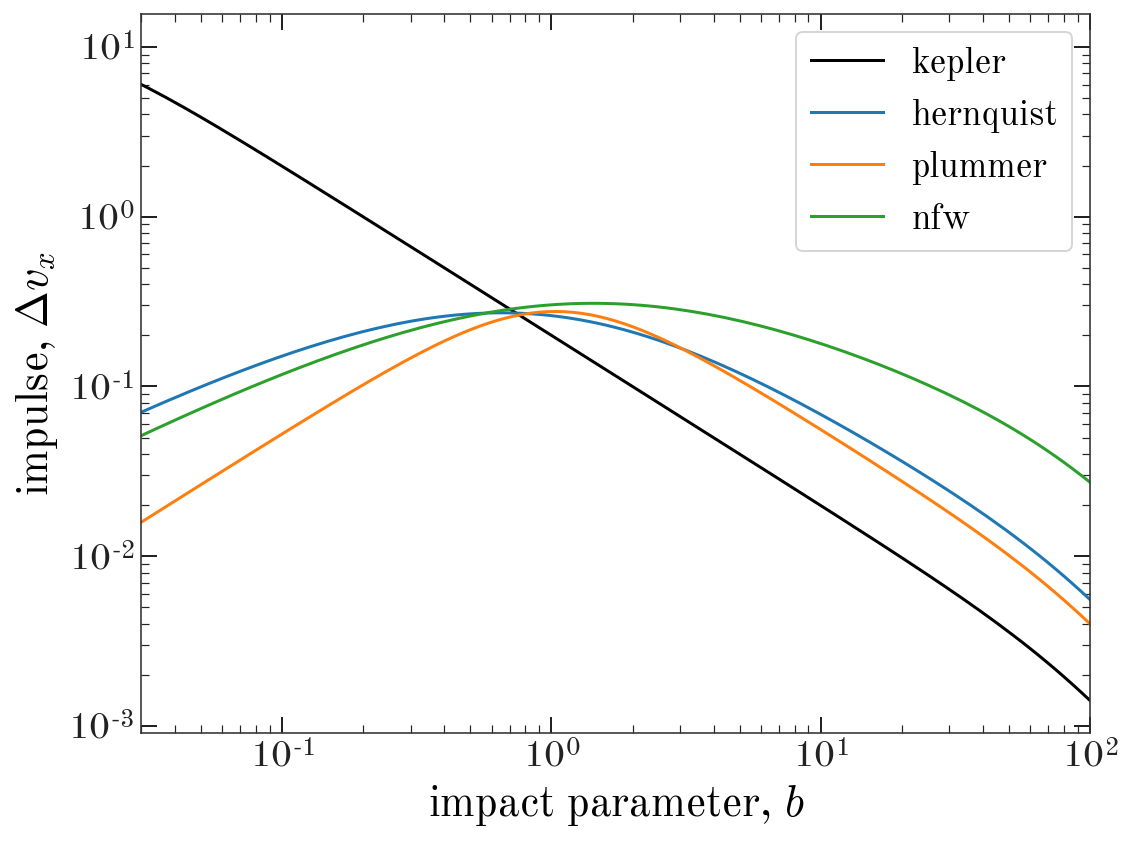

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for k, p in perturbers.items():
    ax.loglog(par_pos[0], -dxs[k], marker='', label=k)
    
ax.legend(fontsize=18, loc='best')
ax.set_xlim(3e-2, 1e2)

ax.set_xlabel('impact parameter, $b$')
ax.set_ylabel(r'impulse, $\Delta v_x$')
fig.tight_layout()

---

## Perturb a test particle w/ different NFW

In [61]:
c = np.array([30., 50, 80.])
M200 = [1e6, 1e7, 1e8]*u.Msun

fac = np.log(1+c) - c/(1+c)
rho0 = 127*u.Msun/u.kpc**3 * 200/3*c**3/fac
rs = np.cbrt(M200/(2*np.pi*rho0) / fac).to(u.pc)
print(rs)

[ 88.63011276 114.56867371 154.26920315] pc


In [96]:
c = np.array([30., 50, 80.]) * 2
M200 = [1e6, 1e7, 1e8]*u.Msun

fac = np.log(1+c) - c/(1+c)
rho0 = 127*u.Msun/u.kpc**3 * 200/3*c**3/fac
rs = np.cbrt(M200/(2*np.pi*rho0) / fac).to(u.pc)
print(rs)

rvir = c * rs

[44.31505638 57.28433686 77.13460157] pc


In [97]:
perturbers = {
    'nfw6': gp.NFWPotential(m=M200[0]/fac[0], r_s=rs[0], units=galactic),
    'nfw7': gp.NFWPotential(m=M200[1]/fac[1], r_s=rs[1], units=galactic),
    'nfw8': gp.NFWPotential(m=M200[2]/fac[2], r_s=rs[2], units=galactic),
}

In [98]:
for i, (k, p) in enumerate(perturbers.items()):
    print(p.mass_enclosed([1., 0, 0]*rvir[i]))

[1000000.00105131] solMass
[10000000.00243299] solMass
[1.e+08] solMass


All coordinates are at the time of impact

In [99]:
perturber_w0 = gd.PhaseSpacePosition([0,0,0]*u.kpc, [0,0,300.]*u.km/u.s)

In [100]:
par_pos = np.zeros((3, 128))
par_pos[0] = np.logspace(0, 4, par_pos.shape[1])
par_vel = np.zeros_like(par_pos)
particle_w0 = gd.PhaseSpacePosition(par_pos*u.pc, par_vel*u.km/u.s)

w0 = gd.combine((perturber_w0, particle_w0))

ext = gp.NullPotential(units=galactic)
tmp = ext.integrate_orbit(w0, dt=-1e-1*u.Myr, t1=0, t2=-100.*u.Myr)

w0_past = tmp[-1]
t0_past = tmp.t[-1]

In [101]:
dxs = {}
for k, p in perturbers.items():
    nbody = gd.DirectNBody(w0_past, particle_potentials=[p] + [None]*particle_w0.shape[0], 
                           units=galactic)
    orbits = nbody.integrate_orbit(t1=t0_past, t2=100.*u.Myr, dt=1e-2*u.Myr)
    dxs[k] = orbits[-1, 1:].v_x

1.3098700777265921 1 / pc
1.3543405744564359 1 / pc
1.3443080240525753 1 / pc


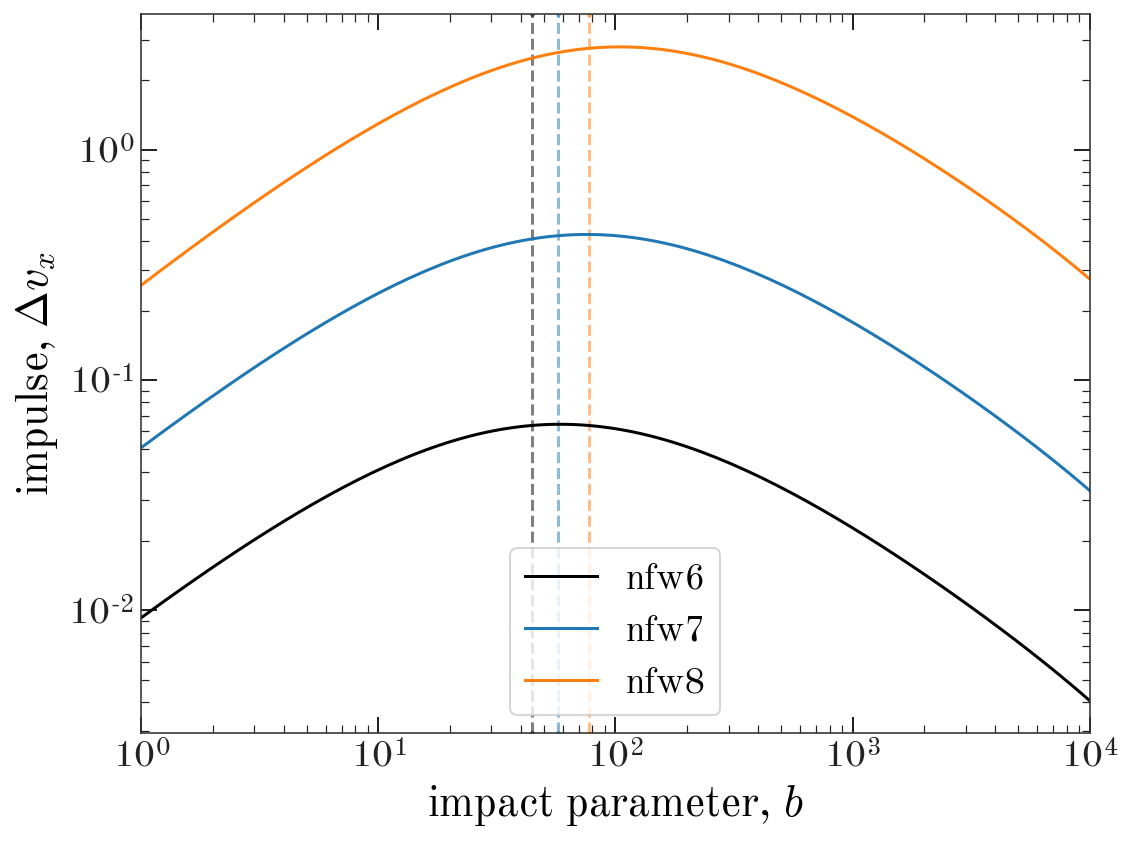

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, (k, p) in enumerate(perturbers.items()):
    l, = ax.loglog(par_pos[0], -dxs[k].to(u.km/u.s), marker='', label=k)
    ax.axvline(rs[i].to_value(u.pc), color=l.get_color(), 
               ls='--', zorder=-10, alpha=0.5)
    
    print(par_pos[0][np.abs(dxs[k]).argmax()] / rs[i])
    
ax.legend(fontsize=18, loc='best')
ax.set_xlim(1, 1e4)

ax.set_xlabel('impact parameter, $b$')
ax.set_ylabel(r'impulse, $\Delta v_x$')
fig.tight_layout()

---

Try numerically integrating to get the impulse from an NFW perturber:

In [118]:
from astropy.constants import G
from scipy.integrate import quad

In [111]:
def func(t, rs, b, v):
    z = v*t
    r = np.sqrt(b**2 + z**2)
    return (r/(r+rs) - np.log(1 + r/rs)) * b/r**3

In [132]:
M200 = 1e7 * u.Msun
c = 50.
f = np.log(1+c) + c/(1+c)
rho0 = 127*u.Msun/u.kpc**3 * 200/3*c**3/f
rs = np.cbrt(M200/(2*np.pi*rho0) / f).to(u.pc)

# b = 100 * u.pc
b = rs
v = 100 * u.km/u.s

res = quad(func, -np.inf, np.inf, args=(rs.to_value(u.pc), 
                                        b.to_value(u.pc),
                                        v.to_value(u.pc/u.Myr)))
dv = G*M200/f * res[0] * u.Myr/u.pc**2
dv.to(u.km/u.s)

<Quantity -0.46900529 km / s>

---

## Perturb a string of orbiting test particles

In [288]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [372]:
def animate_impact(orbits, rot_frame, frame_step=1):
    rot_orbits = orbits.to_frame(rot_frame, t=orbits.t)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                             sharey=True, constrained_layout=True)
    
    for ax in axes:
        ax.set_aspect('equal')

    line1, = axes[0].plot([], [], '.-', color='k', lw=0.5)
    line2, = axes[1].plot([], [], '.-', color='k', lw=0.5)

    subhalo_line1, = axes[0].plot([], [], 
                                  marker='o', color='tab:red', ls='none')
    subhalo_line2, = axes[1].plot([], [], 
                                  marker='o', color='tab:red', ls='none')
    
    lim = 0.4
    axes[0].set_xlim(-lim+1, lim+1)
    axes[0].set_ylim(-lim, lim)

    axes[1].set_xlim(-lim, lim)
    axes[1].set_ylim(-lim, lim)
    
    axes[0].set_xlabel('$x$', fontsize=30)
    axes[0].set_ylabel('$y$', fontsize=30)
    
    axes[1].set_xlabel('$y$', fontsize=30)
    axes[1].set_ylabel('$z$', fontsize=30)

    def animate(i):
        xyz = rot_orbits[i, 1:].xyz

        line1.set_data(xyz.value[0], xyz.value[1])
        line2.set_data(xyz.value[1], xyz.value[2])

        xyz = rot_orbits[i, 0].xyz

        if np.abs(orbits.t[i]) < 0.2:
            subhalo_line1.set_data(xyz.value[0], xyz.value[1])
            subhalo_line2.set_data(xyz.value[1], xyz.value[2])
        else:
            subhalo_line1.set_data(999, 999)
            subhalo_line2.set_data(999, 999)

        return line1, line2, subhalo_line1, subhalo_line2 

    ani = FuncAnimation(fig, animate, 
                        frames=np.arange(0, rot_orbits.ntimes, frame_step),
                        interval=20, blit=True)
    return ani

In [327]:
from astropy.constants import G
v_unit = 220 * u.km/u.s
r_unit = 8 * u.kpc

m_unit = (v_unit**2 * r_unit / G).to(u.Msun)
t_unit = np.sqrt(r_unit**3 / (G*m_unit)).to(u.Myr)
m_unit, t_unit

(<Quantity 9.00273071e+10 solMass>, <Quantity 35.55608079 Myr>)

In [346]:
(r_unit * 1.25e-2).to(u.pc)

<Quantity 100. pc>

In [363]:
perturber_mass = 1.111e-4
perturber_size = 1.25e-2 / 4

print('{:.1e}'.format((perturber_mass * m_unit).to(u.Msun)) + 
      ' {:.0f}'.format((perturber_size * r_unit).to(u.pc)))

1.0e+07 solMass 25 pc


In [378]:
perturber_pot = gp.NFWPotential(m=1/(np.log(2) - 0.5) * perturber_mass, 
                                r_s=perturber_size, 
                                units=dimensionless)

In [379]:
ext_pot = gp.LogarithmicPotential(1.*np.sqrt(2), 1., 1, 1, 1, units=dimensionless)

In [386]:
init_tmp = ext_pot.integrate_orbit([1., 0, 0, 
                                    0, 1., 0], 
                                   dt=-1e-3, n_steps=300)
init_orbit = ext_pot.integrate_orbit(init_tmp[-1], 
                                     dt=1e-3, n_steps=2*init_tmp.ntimes-1)
particle_w0 = gd.PhaseSpacePosition(pos=init_orbit.pos, vel=init_orbit.vel)
particle_w0.shape

(602,)

In [387]:
static_frame = gp.StaticFrame(dimensionless)
Omega = (init_tmp[0].v_y / init_tmp[0].x)
rot_frame = gp.ConstantRotatingFrame(Omega * [0, 0, 1], units=dimensionless)

In [399]:
t_unit*10 / 250

<Quantity 1.42224323 Myr>

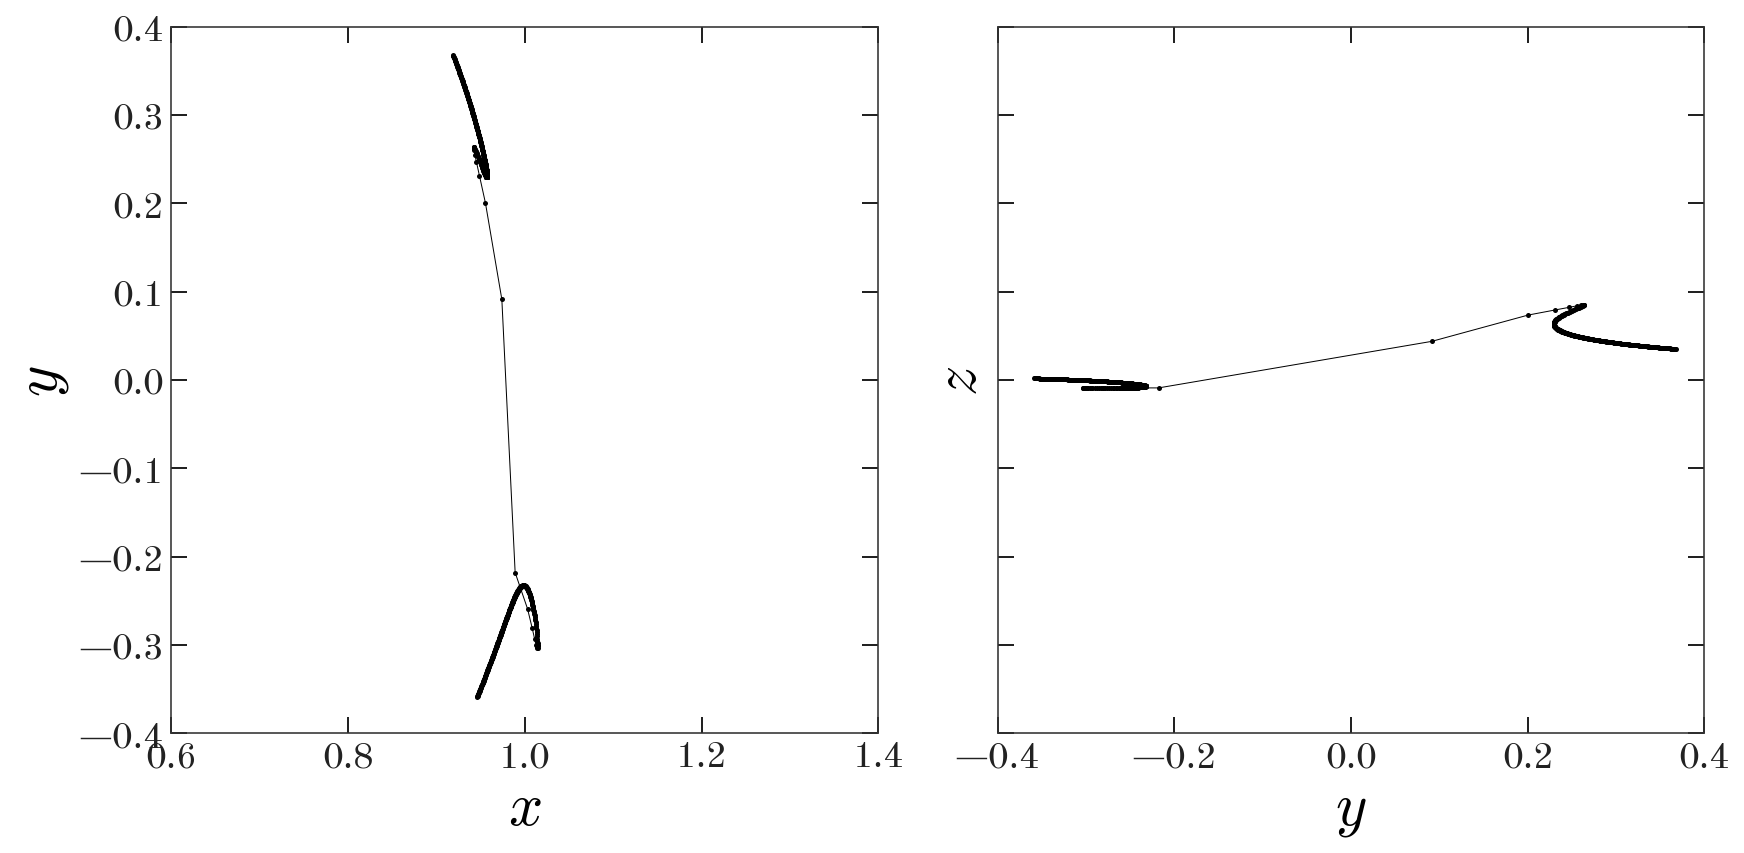

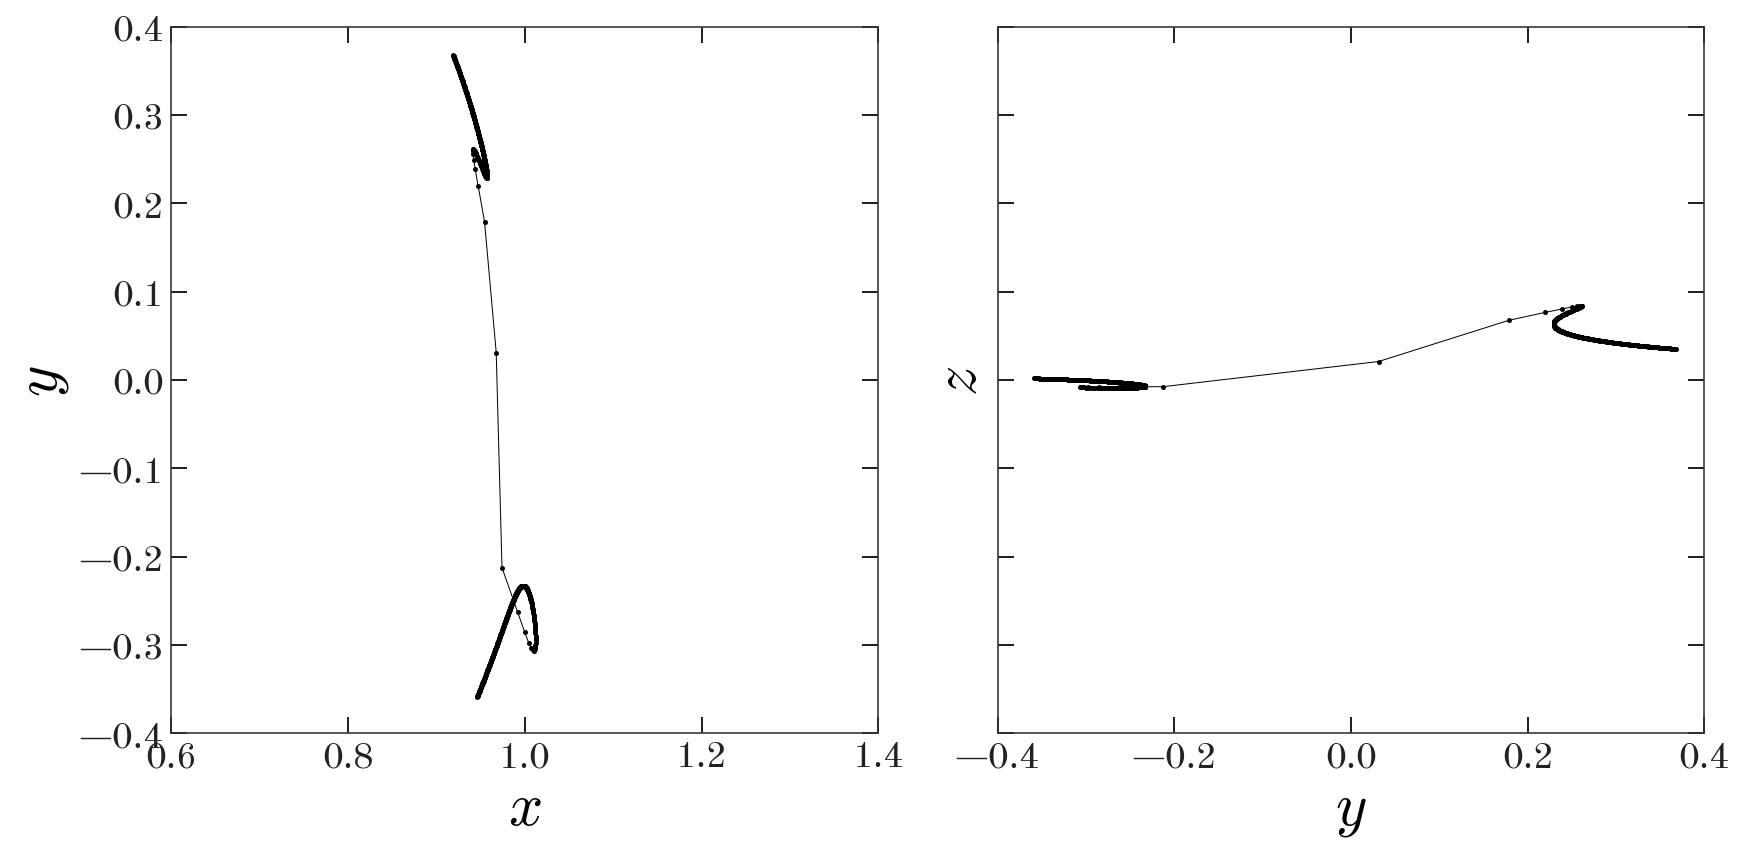

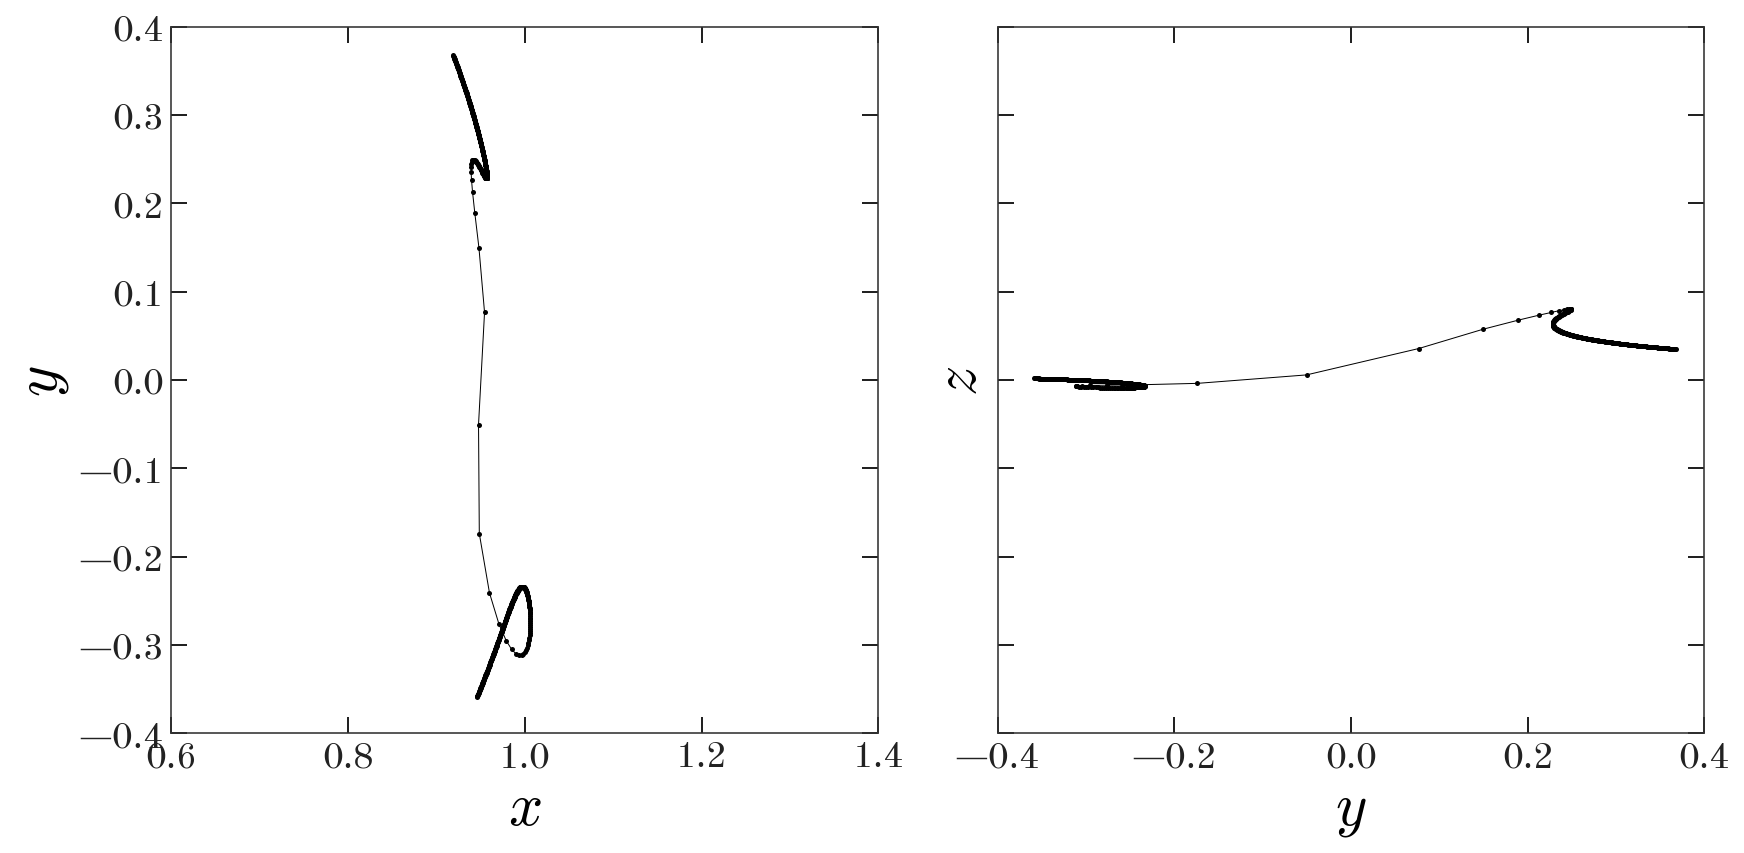

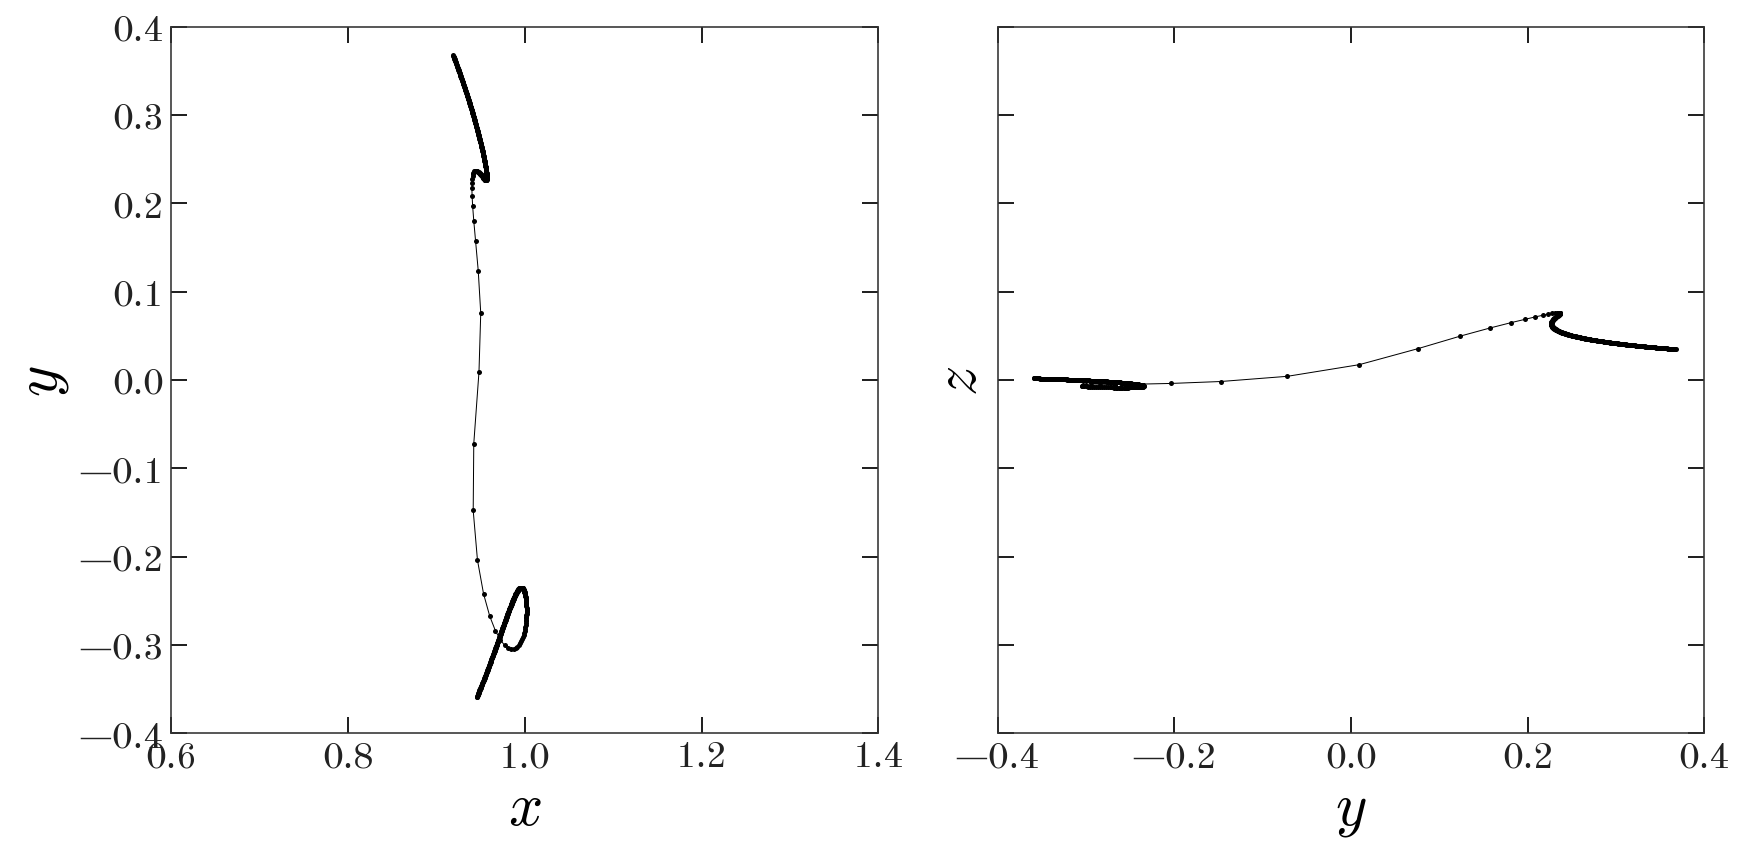

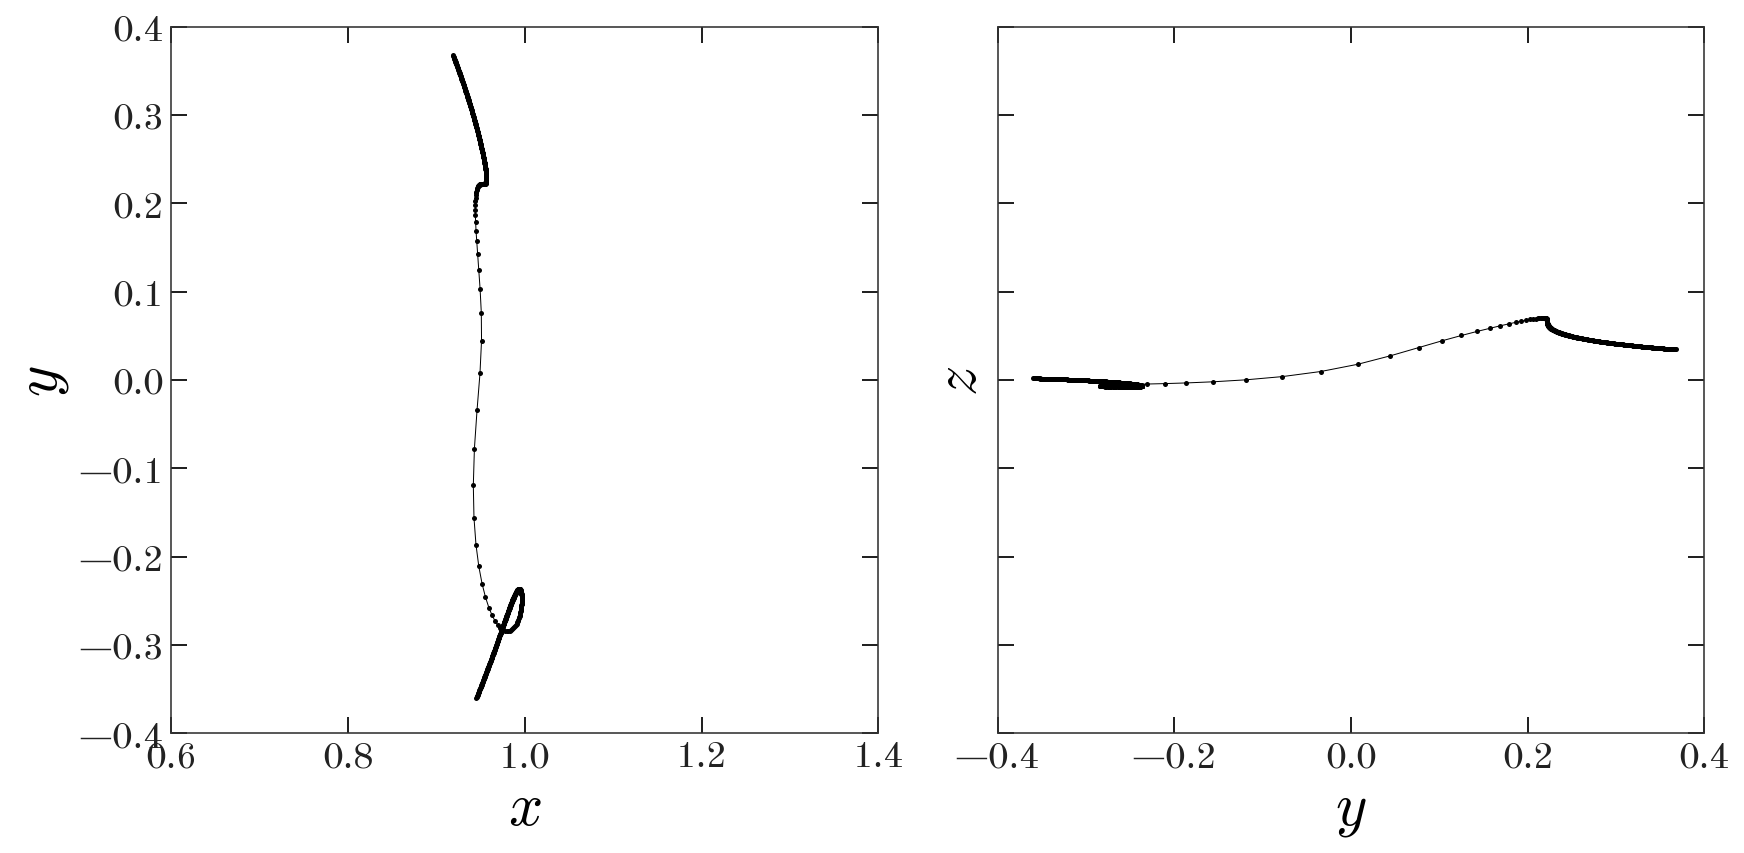

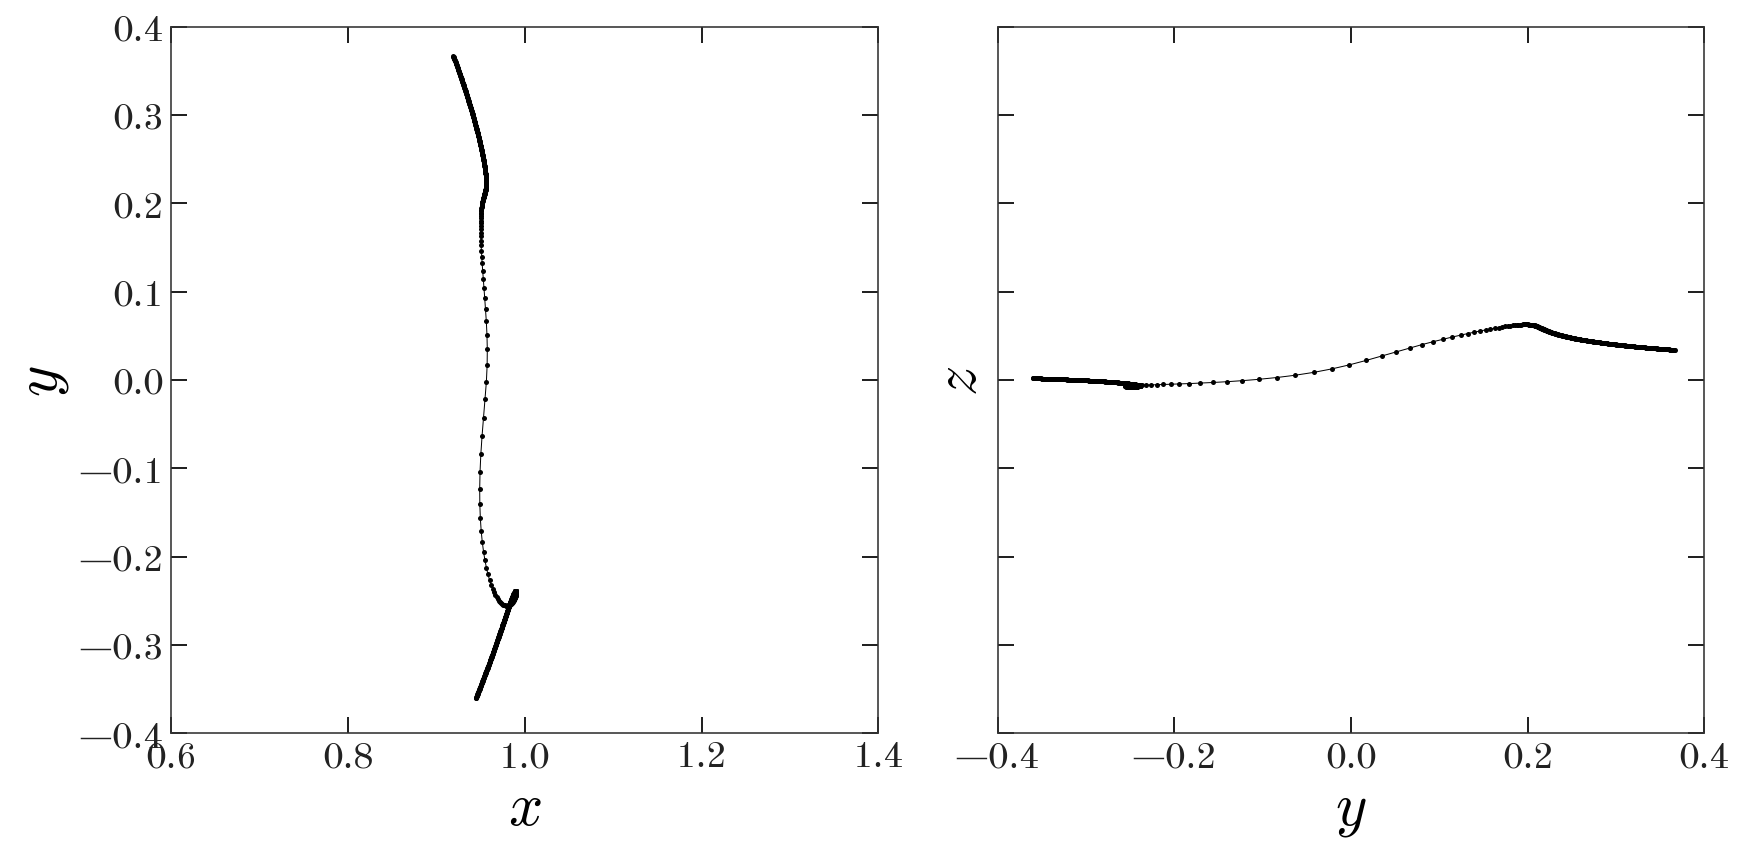

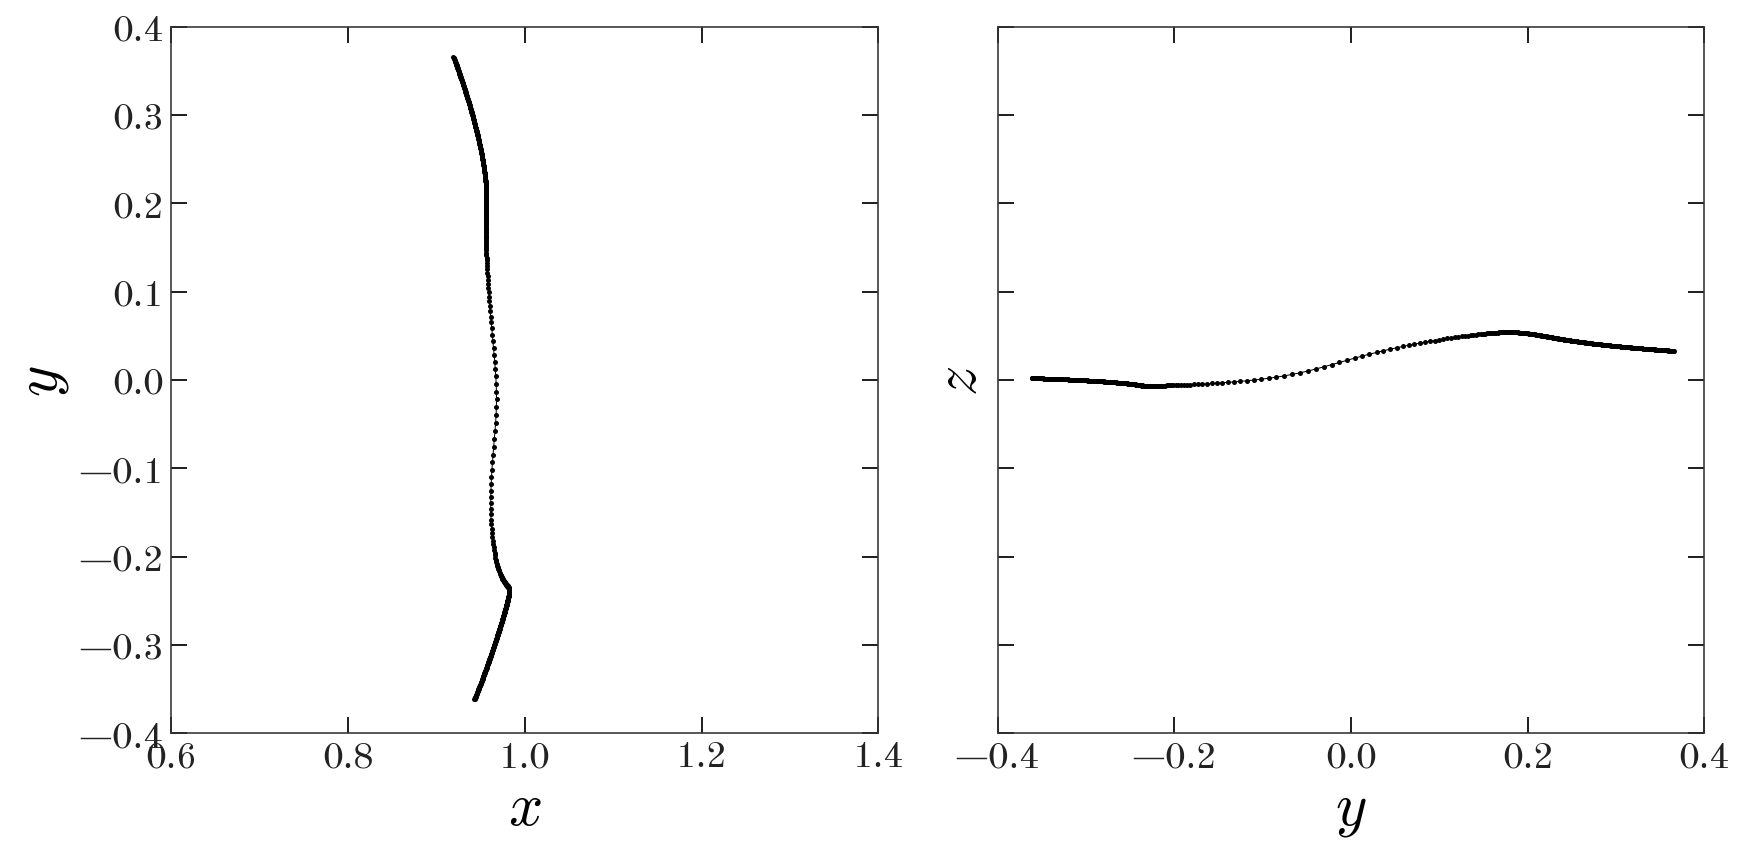

In [400]:
n_x = 8
dt = 1e-3

for frac_x in [0.01, 0.1, 0.5, 1, 2, 4, 8]:
    x = frac_x * perturber_size
    
    perturber_w0 = gd.PhaseSpacePosition([1 + x,0,0], [0,0,1.])
    w0 = gd.combine((perturber_w0, particle_w0))
    
    tmp = ext_pot.integrate_orbit(w0, dt=-dt, t1=0, t2=-2.)
    w0_past = tmp[-1]
    t0_past = tmp.t[-1]
    
    ppots = [perturber_pot] + [None]*particle_w0.shape[0]
    nbody = gd.DirectNBody(w0_past, particle_potentials=ppots, 
                           units=dimensionless, external_potential=ext_pot)
    orbits = nbody.integrate_orbit(t1=t0_past, t2=10., dt=dt)
            
    ani = animate_impact(orbits, rot_frame, frame_step=50)
    ani.save('../movies/{:.2e}.mp4'.format(frac_x), dpi=250)

---

## Perturb a string of test particles to check vr condition

In [435]:
perturber_pot = gp.NFWPotential(m=1e-6/(np.log(2) - 0.5), 
                                r_s=0.1, 
                                units=dimensionless)

In [436]:
ext_pot = gp.NullPotential(dimensionless)

In [437]:
init_tmp = ext_pot.integrate_orbit([0, 0, 0, 
                                    0, 0, 1.], 
                                   dt=-1e-3, n_steps=300)
init_orbit = ext_pot.integrate_orbit(init_tmp[-1], 
                                     dt=1e-3, n_steps=2*init_tmp.ntimes-1)
particle_w0 = gd.PhaseSpacePosition(pos=init_orbit.pos, vel=init_orbit.vel)
particle_w0.shape

(602,)

In [444]:
perturber_w0 = gd.PhaseSpacePosition(
    pos=coord.CylindricalRepresentation(rho=0.5*u.one, phi=0*u.deg, z=0),
    vel=coord.CylindricalDifferential(d_rho=0*u.one, d_phi=0.2*u.rad, d_z=0.8))
perturber_w0 = perturber_w0.cartesian

In [445]:
w0 = gd.combine((perturber_w0, particle_w0))

dt = 1e-3
tmp = ext_pot.integrate_orbit(w0, dt=-dt, t1=0, t2=-1.)
w0_past = tmp[-1]
t0_past = tmp.t[-1]

ppots = [perturber_pot] + [None]*particle_w0.shape[0]
nbody = gd.DirectNBody(w0_past, particle_potentials=ppots, 
                       units=dimensionless, external_potential=ext_pot)
orbits = nbody.integrate_orbit(t1=t0_past, t2=1., dt=dt)

In [446]:
orbits.shape

(2000, 603)

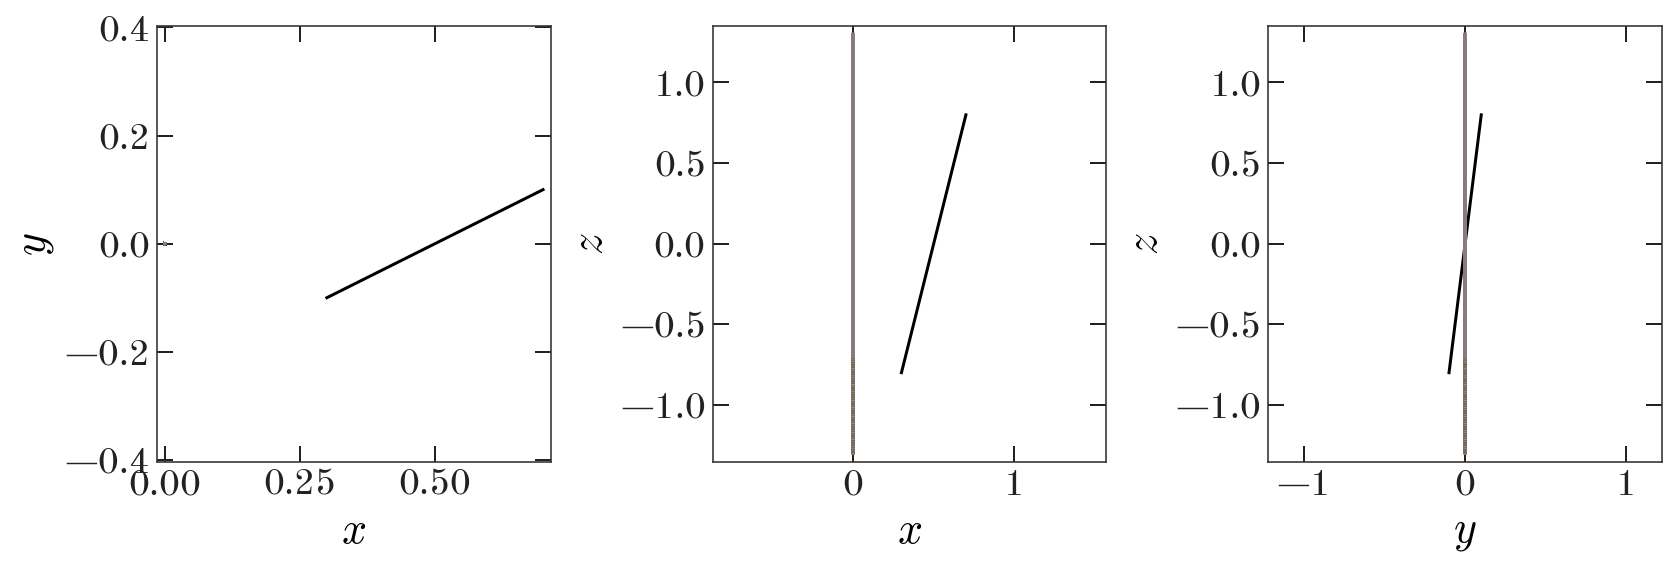

In [447]:
_ = orbits.plot()

In [448]:
dx = orbits[:, 0:1].xyz - orbits[:, 1:].xyz
dr = np.linalg.norm(dx[..., 301-5:301+5], axis=0)

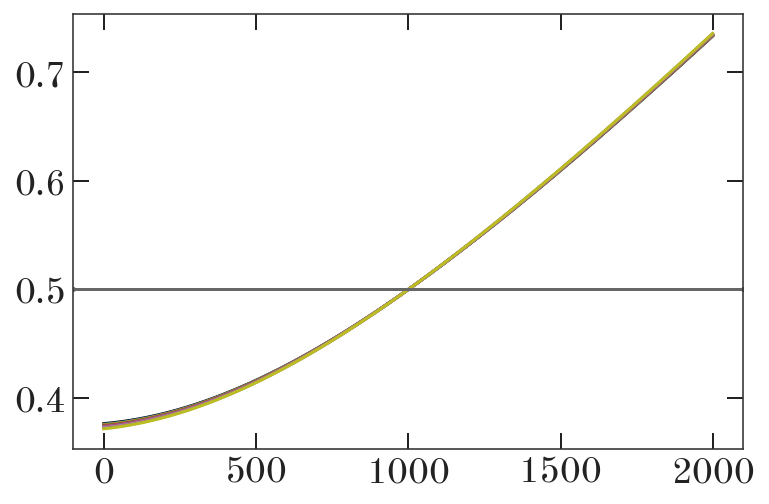

In [449]:
for i in range(dr.shape[1]):
    plt.plot(dr[:, i], marker='')
    
plt.axhline(0.5)